# Description

This notebook creates different workload patterns (datasets) for experimentation purposes. It also performs analysis on these datasets.

# Creating time series

In [12]:
# !pip install darts

np.random.seed(42)
# Define the quantity of observations
LENGTH = 4 * 24 * 365  # one year

# Path to the datasets
PATH = './datasets/'

# The initial data
START_DATE = datetime.datetime(2022, 1, 1)

# Parse de data into min, hours, days, weekdays, months, and years
def feature_engineering(dataset):
    # # 2000-01-01 03:15:00 - time
    dataset = dataset.groupby(
        ['time'], dropna=True, as_index=True).sum().reset_index()

    # #  Format data
    dataset['time'] = pd.to_datetime(
        dataset['time'], format='%Y-%m-%d %H:%M:%S')

    # Add hour and minute
    dataset['hour'] = [d.hour for d in dataset['time']]
    dataset['minute'] = [d.minute for d in dataset['time']]

    # Add day, month, and year
    dataset['day'] = [d.day for d in dataset['time']]
    dataset['month'] = [d.month for d in dataset['time']]
    dataset['year'] = [d.year for d in dataset['time']]

    # Day of Week (Monday=0)
    dataset['weekday'] = dataset['time'].dt.weekday
    return dataset


## Concept Drift

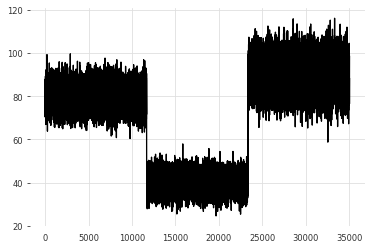

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import datetime


# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(80, 5, int(LENGTH/3))
dist_b = random_state.normal(40, 4, int(LENGTH/3))
dist_c = random_state.normal(90, 7, int(LENGTH/3))

# Concatenate data to simulate a data stream with 2 drifts
stream = np.concatenate((dist_a, dist_b, dist_c))
df = pd.DataFrame(stream)
df.columns = ['count']

# Create columns
df.insert(0, 'time', '')
df['time'] = (pd.date_range(start=START_DATE,
                            periods=df.shape[0],
                            freq='15min'))

df = feature_engineering(df)
df['count'].plot()
df.to_csv(PATH+'concept_drift.csv')


# Auxiliary function to plot the data
# def plot_data(dist_a, dist_b, dist_c, drifts=None):
#     fig = plt.figure(figsize=(7, 3), tight_layout=True)
#     gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
#     ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
#     ax1.grid()
#     ax1.plot(stream, label='Stream')
#     ax2.grid(axis='y')
#     ax2.hist(dist_a, label=r'$dist_a$')
#     ax2.hist(dist_b, label=r'$dist_b$')
#     ax2.hist(dist_c, label=r'$dist_c$')
#     if drifts is not None:
#         for drift_detected in drifts:
#             ax1.axvline(drift_detected, color='red')
#     plt.show()


# plot_data(dist_a, dist_b, dist_c)


## Linear normal with litle variations

<AxesSubplot:>

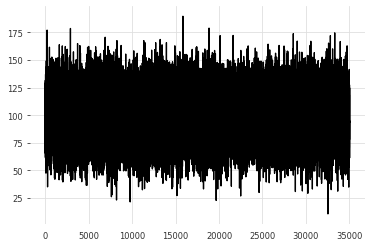

In [14]:
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(100, 20, int(LENGTH))
df = pd.DataFrame(dist_a)

df.columns = ['count']
df.insert(0, 'time', '')
df['time'] = (pd.date_range(start=START_DATE,
                            periods=df.shape[0],
                            freq='15min'))
df = feature_engineering(df)
df.to_csv(PATH + 'normal.csv')
df['count'].plot()


## Linear growing

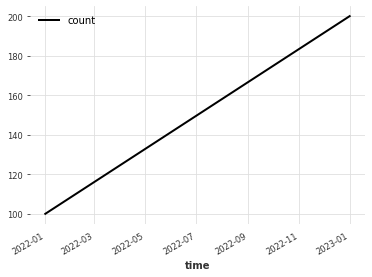

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

from darts.utils import timeseries_generation as tg
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
    constant_timeseries,
    gaussian_timeseries,
    random_walk_timeseries
)


# Linear time series
series_linear = (tg.linear_timeseries(start_value=100,
                                      start=pd.Timestamp(START_DATE),
                                      end_value=200,
                                      length=LENGTH,
                                      freq='15min',
                                      column_name='count'))
series_linear.plot()

series_linear = series_linear.pd_dataframe(copy=True)
dataset = feature_engineering(series_linear)
dataset.to_csv(PATH + 'linear_growing.csv')


## Constant

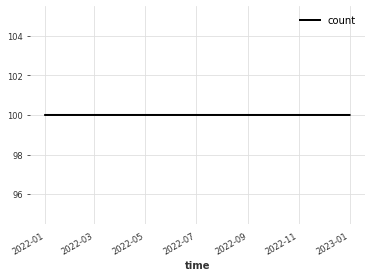

In [16]:

# Constant time series
series_constant = (tg.constant_timeseries(value=100,
                                          start=pd.Timestamp(START_DATE),
                                          length=LENGTH,
                                          freq='15min',
                                          column_name='count'))
series_constant.plot()
df = series_constant.pd_dataframe(copy=True)
df = feature_engineering(df)
df.to_csv(PATH + 'constant.csv')


## Gaussian

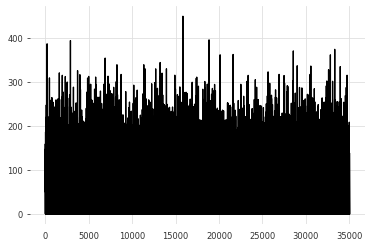

In [17]:
# Gaussian time series
series_gaussian = (tg.gaussian_timeseries(mean=1,
                                          start=pd.Timestamp(START_DATE),
                                          std=100,
                                          freq='15min',
                                          length=LENGTH,
                                          column_name='count'))
# series_gaussian.plot()
df = series_gaussian.pd_dataframe(copy=True)
min = df['count'].min()
df['count'] = np.where(df['count'] < 0, 0, df['count'])
df = feature_engineering(df)
df['count'].plot()
df.to_csv(PATH + 'gaussian.csv')

## Random Walk

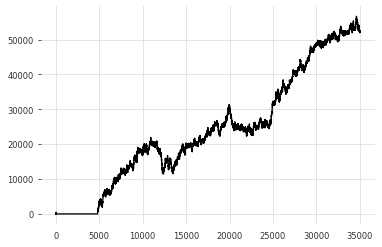

In [18]:
# Creates a random walk univariate TimeSeries, where each step is obtained by sampling a gaussian distribution
#  with mean mean and standard deviation std.
series_random_walk = (tg.random_walk_timeseries(mean=1,
                                                std=100,
                                                start=pd.Timestamp(START_DATE),
                                                length=LENGTH,
                                                freq='15min',
                                                column_name='count'))


# series_random_walk.plot()
df = series_random_walk.pd_dataframe(copy=True)
min = df['count'].min()
df['count'] = np.where(df['count'] < 0, 0, df['count'])
df = feature_engineering(df)
df['count'].plot()
df.to_csv(PATH + 'random.csv')

## Sine wave function

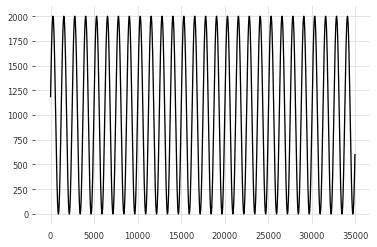

In [19]:
import datetime
import pandas as pd
import numpy as np

day = 24 * 60 * 60
year = 365.2425 * day

def load_dataframe() -> pd.DataFrame:
    """ Create a time series x sin wave dataframe. """
    df = pd.DataFrame(columns=['time', 'count'])
    df['time'] = pd.date_range(
        start='2022-01-01', end='2022-12-31', freq='15min')
    df['count'] = 1 + np.sin(df['time'].astype('int64') // 1e9 * (56 * np.pi / year))
    df['count'] = (df['count'] * 1000).round(2)
    df['time'] = df['time'].apply(lambda d: d.strftime('%Y-%m-%d %H:%M:%S'))
    return df

df = load_dataframe()
df = feature_engineering(df)
df['count'].plot()
df.to_csv(PATH + 'sine.csv')

# Time Series Analysis

## Trend

## Seasonality

## White noise